<a href="https://colab.research.google.com/github/ZItusLi/Bakteri/blob/main/Train_YOLO_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Thu Nov 27 06:38:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# Unzip images to a custom data folder
!unzip -q /content/data.zip -d /content/custom_data

In [5]:
!pip install ultralytics

## 5.1 Training Parameters
Now that the data is organized and the config file is created, we're ready to start training! First, there are a few important parameters to decide on. Visit my article on [Training YOLO Models Locally](https://www.ejtech.io/learn/train-yolo-models) to learn more about these parameters and how to choose them.

**Model architecture & size (`model`):**

There are several YOLO11 models sizes available to train, including `yolo11n.pt`, `yolo11s.pt`, `yolo11m.pt`, `yolo11l.pt`, and `yolo11xl.pt`. Larger models run slower but have higher accuracy, while smaller models run faster but have lower accuracy. I made a brief YouTube video that compares performance of different YOLO models on a Raspberry Pi 5 and a laptop with a RTX 4050 GPU, [check it out here to get a sense of their speed accuracy](https://youtu.be/_WKS4E9SmkA). If you aren't sure which model size to use, `yolo11s.pt` is a good starting point.

You can also train YOLOv8 or YOLOv5 models by substituting `yolo11` for `yolov8` or `yolov5`.


**Number of epochs (`epochs`)**

In machine learning, one “epoch” is one single pass through the full training dataset. Setting the number of epochs dictates how long the model will train for. The best amount of epochs to use depends on the size of the dataset and the model architecture. If your dataset has less than 200 images, a good starting point is 60 epochs. If your dataset has more than 200 images, a good starting point is 40 epochs.


**Resolution (`imgsz`)**

Resolution has a large impact on the speed and accuracy of the model: a lower resolution model will have higher speed but less accuracy. YOLO models are typically trained and inferenced at a 640x640 resolution. However, if you want your model to run faster or know you will be working with low-resolution images, try using a lower resolution like 480x480.


## 5.2 Run Training!

Run the following code block to begin training. If you want to use a different model, number of epochs, or resolution, change `model`, `epochs`, or `imgsz`.

In [21]:
!yolo detect train data=/content/custom_data/data.yaml model=yolo11l.pt epochs=100 imgsz=640

Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/custom_data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, po

The training algorithm will parse the images in the training and validation directories and then start training the model. At the end of each training epoch, the program runs the model on the validation dataset and reports the resulting mAP, precision, and recall. As training continues, the mAP should generally increase with each epoch. Training will end once it goes through the number of epochs specified by `epochs`.

> **NOTE:** Make sure to allow training to run to completion, because an optimizer runs at the end of training that strips out unneeded layers from the model.

The best trained model weights will be saved in `content/runs/detect/train/weights/best.pt`. Additional information about training is saved in the `content/runs/detect/train` folder, including a `results.png` file that shows how loss, precision, recall, and mAP progressed over each epoch.

#6.&nbsp;Test Model

The model has been trained; now it's time to test it! The commands below run the model on the images in the validation folder and then display the results for the first 10 images. This is a good way to confirm your model is working as expected. Click Play on the blocks below to see how your model performs.

In [22]:
!yolo detect predict model=runs/detect/train5/weights/best.pt source=custom_data/valid/images save=True

Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 190 layers, 25,280,854 parameters, 0 gradients, 86.6 GFLOPs

image 1/16 /content/custom_data/valid/images/DESOKEX_N_CR_t-6_2025-11-21_10-48-45_jpg.rf.6b0c8c722115cece2cb1d54f198fe257.jpg: 640x640 6 Bakteris, 47.5ms
image 2/16 /content/custom_data/valid/images/DESOKEX_N_CR_t-6_2025-11-21_10-48-50_jpg.rf.9f31e270bd6925c87dc4f79a5fa97d4e.jpg: 640x640 6 Bakteris, 47.4ms
image 3/16 /content/custom_data/valid/images/DESOLEX_N_CR_t-0_2025-11-21_11-02-40_jpg.rf.7630cb3304c569ea0517fbb8152c0f8c.jpg: 640x640 6 Bakteris, 47.3ms
image 4/16 /content/custom_data/valid/images/DESOLEX_N_CR_t-6_2025-11-21_11-04-34_jpg.rf.08717fc40e468318473165559ace128f.jpg: 640x640 6 Bakteris, 47.3ms
image 5/16 /content/custom_data/valid/images/DESOLEX_N_CR_t-6_2025-11-21_11-18-08_jpg.rf.5061a06df2298f0de24f757e1b2ef88b.jpg: 640x640 6 Bakteris, 31.5ms
image 6/16 /content/custom_data/valid/images/DESOLEX_N_CR_t-6

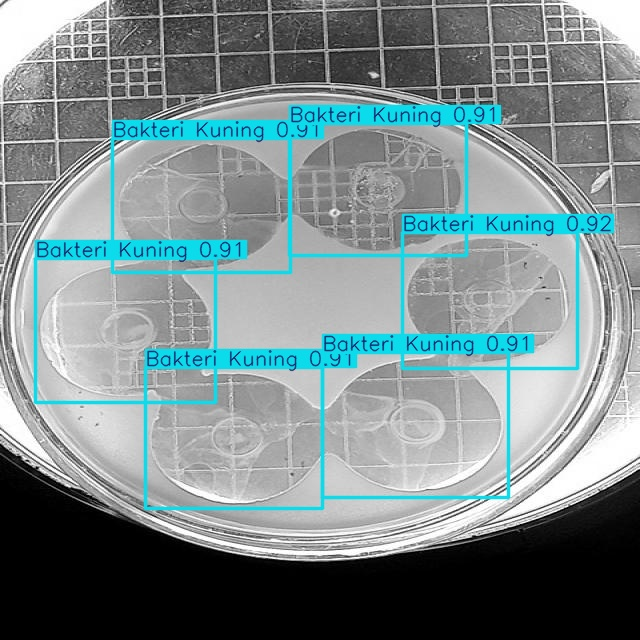

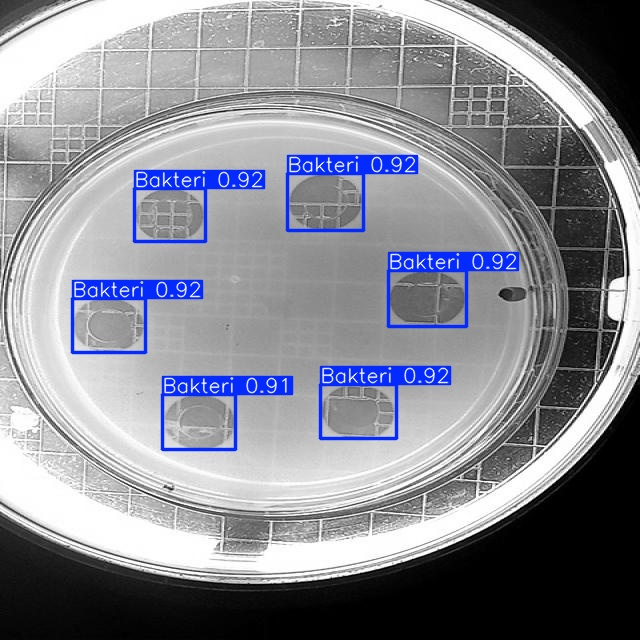

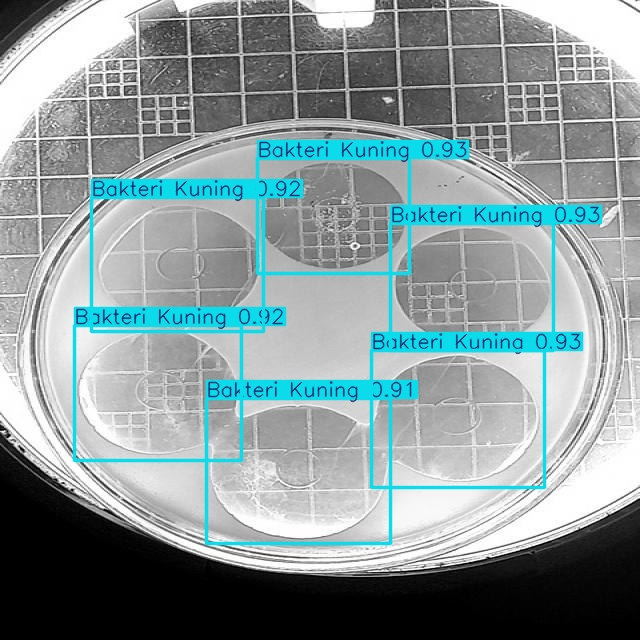

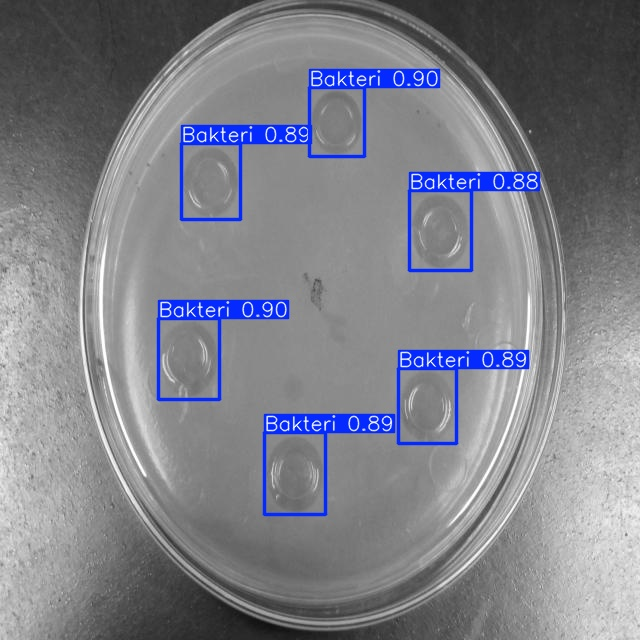

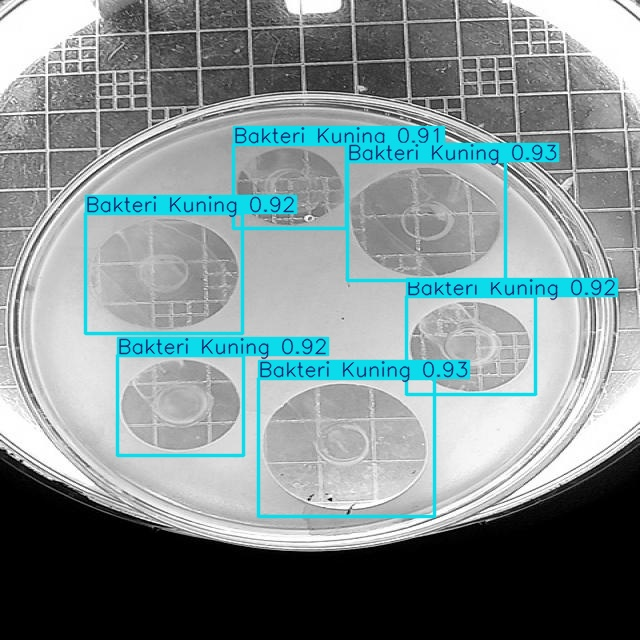

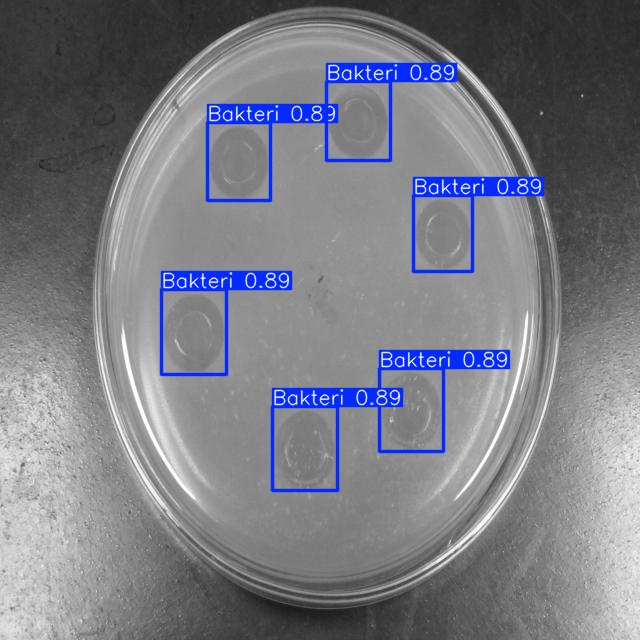

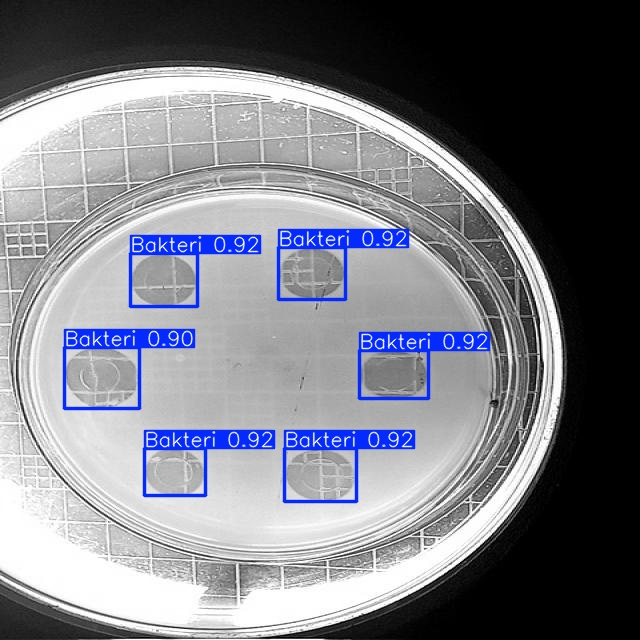

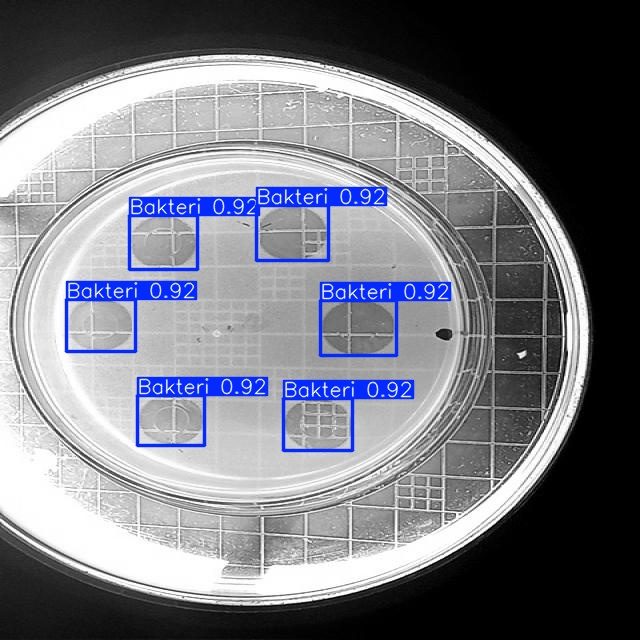

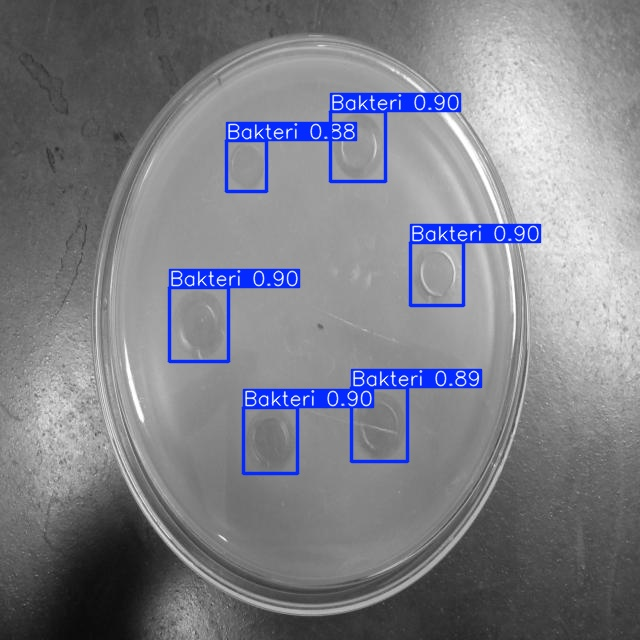

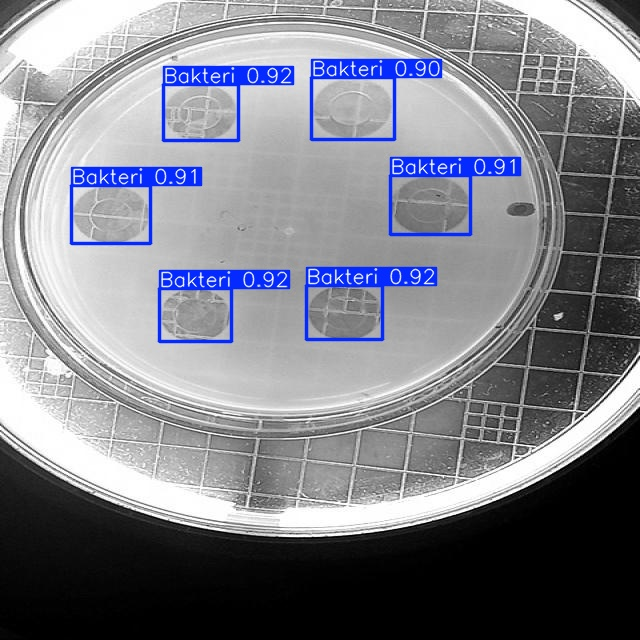

In [23]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict3/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')


The model should draw a box around each object of interest in each image. If it isn't doing a good job of detecting objects, here are a few tips:

1. Double-check your dataset to make sure there are no labeling errors or conflicting examples.
2. Increase the number of epochs used for training.
3. Use a larger model size (e.g. `yolo11l.pt`).
4. Add more images to the training dataset. See my [dataset video](https://www.youtube.com/watch?v=v0ssiOY6cfg) for tips on how to capture good training images and improve accuracy.

You can also run the model on video files or other images images by uploading them to this notebook and using the above `!yolo detect predict` command, where `source` points to the location of the video file, image, or folder of images. The results will be saved in `runs/detect/predict`.

Drawing boxes on images is great, but it isn't very useful in itself. It's also not very helpful to just run this models inside a Colab notebook: it's easier if we can just run it on a local computer. Continue to the next section to see how to download your newly trained model and run it on a local device.

#7.&nbsp;Deploy Model

Now that your custom model has been trained, it's ready to be downloaded and deployed in an application! YOLO models can run on a wide variety of hardware, including PCs, embedded systems, and phones. Ultralytics makes it easy to convert the YOLO models to various formats (`tflite`, `onnx`, etc.) and deploy them in a variety of environments.

This section shows how to download the model and provides links to instructions for deploying it on your PC and edge devices like the Raspberry Pi.

## 7.1 Download YOLO Model

First, zip and download the trained model by running the code blocks below.

The code creates a folder named `my_model`, moves the model weights into it, and renames them from `best.pt` to `my_model.pt`. It also adds the training results in case you want to reference them later. It then zips the folder as `my_model.zip`.

In [24]:
# Create "my_model" folder to store model weights and train results
!mkdir /content/yolo_model
!cp /content/runs/detect/train5/weights/best.pt /content/yolo_model/yolo11s.pt
!cp -r /content/runs/detect/train5 /content/yolo_model

# Zip into "my_model.zip"
%cd yolo_model
!zip /content/yolo_model.zip yolo11s.pt
!zip -r /content/yolo_model.zip train5
%cd /content

mkdir: cannot create directory ‘/content/yolo_model’: File exists
/content/yolo_model
  adding: yolo11s.pt (deflated 8%)
  adding: train5/ (stored 0%)
  adding: train5/labels.jpg (deflated 39%)
  adding: train5/train_batch360.jpg (deflated 9%)
  adding: train5/BoxF1_curve.png (deflated 18%)
  adding: train5/val_batch0_pred.jpg (deflated 7%)
  adding: train5/train_batch1.jpg (deflated 4%)
  adding: train5/BoxR_curve.png (deflated 19%)
  adding: train5/train_batch2.jpg (deflated 2%)
  adding: train5/val_batch0_labels.jpg (deflated 8%)
  adding: train5/confusion_matrix.png (deflated 33%)
  adding: train5/results.csv (deflated 64%)
  adding: train5/results.png (deflated 8%)
  adding: train5/train_batch0.jpg (deflated 3%)
  adding: train5/args.yaml (deflated 53%)
  adding: train5/confusion_matrix_normalized.png (deflated 32%)
  adding: train5/train_batch362.jpg (deflated 10%)
  adding: train5/train_batch361.jpg (deflated 7%)
  adding: train5/weights/ (stored 0%)
  adding: train5/weights/las

In [25]:
# This takes forever for some reason, you can also just download the model from the sidebar
from google.colab import files

files.download('/content/yolo_model/yolo11s.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 7.2 Deploy YOLO Model on Local Devices

Next, we'll take our downloaded model and run it on a local device. This section provides instructions showing how to deploy YOLO models on various devices.

I wrote a basic Python script, `yolo_detect.py`, that shows how to load a model, run inference on an image source, parse the inference results, and display boxes around each detected class in the image. The [script](https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/blob/main/yolo_detect.py) gives an example of how to work with Ultralytics YOLO models in Python, and it can be used as a starting point for more advanced applications.

### 7.2.1 Deploy on PC (Windows, Linux, or macOS)

The easiest way to run Ultralytics models on a PC is using Anaconda. Anaconda sets up a virtual Python environment and allows you to easily install Ultralytics and PyTorch. It automatically installs CUDA and cuDNN, which allows you to speed up model inference with your NVIDIA GPU.

> **NOTE:** My YouTube video (link to be added) shows how to deploy your model on a PC. It walks through the following steps, so watch the video if you prefer having visual instructions.

**1. Download and Install Anaconda**

Go to the Anaconda download page at https://anaconda.com/download, click the “skip registration” button, and then download the package for your OS. When it's finished downloading, run the installer and click through the installation steps. You can use the default options for installation.

**2. Set up virtual environment**

Once it's installed, run Anaconda Prompt from the Start Bar. (If you're on macOS or Linux, just open a command terminal).

Issue the following commands to create a new Python environment and activate it:

```
conda create --name yolo-env1 python=3.12 -y
conda activate yolo-env1
```

Install Ultralytics (which also installs import libraries like OpenCV-Python, Numpy, and PyTorch) by issuing the following command:

```
pip install ultralytics
```

If you have an NVIDIA GPU, you can install the GPU-enabled version of PyTorch by issuing the following command:

```
pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
```

**3. Extract downloaded model**
Take the `my_model.zip` file you downloaded in Step 7.1 and unzip it to a folder on your PC. In the Anaconda Prompt terminal, move into the unzipped folder using:

```
cd path/to/folder
```

**4. Download and run yolo_detect.py**

Download the `yolo_detect.py` script into the `my_model` folder using:

```
curl -o yolo_detect.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/yolo_detect.py
```

Alright! We're ready to run the script. To run inference with a yolov8s model on a USB camera at 1280x720 resolution, issue:

```
python yolo_detect.py --model my_model.pt --source usb0 --resolution 1280x720
```

A window will appear showing a live feed from your webcam with boxes drawn around detected objects in each frame.

You can also run the model on an video file, image, or folder of images. To see a full list of arguments for `yolo_detect.py`, issue `python yolo_detect.py --help` or see the [README file](https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/blob/main/README.md).




### 7.2.2 Deploy on Raspberry Pi

Keep an eye out for an article showing how to convert YOLO models to NCNN format and run them on the Raspberry Pi!

# 8.&nbsp;Conclusion

Congratulations! You've successfully trained and deployed a YOLO object detection model. 😀

Next, you can extend your application beyond just drawing boxes and counting objects. Add functionality like logging the number of objects detected over time or taking a picture when certain objects are detected. Check out some example applications at our GitHub repository: https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models

Thanks for working through this notebook, and good luck with your projects!

# Appendix: Common Errors

If you run into any errors working through this notebook, please do the following:


- Double-check that the dataset files are set up in the correct folder structure
- Make sure there are no typos or errors in your labelmap file
- Google search the error to look for solutions

If none of those help, please submit an [Issue](https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/issues) on the GitHub page. In this section, I will add resolutions to common errors as they come up.